# Transfer Learning with Pre-trained Models
Use in-build models with pre-trained weights and apply them to the Food-11 dataset.



1. **ResNet-50**: Selected for its deep architecture that has residual connections, enabling strong feature learning and high performance in complex image classification tasks like this Food-11 image dataset which has 11 categories.
  
2. **MobileNetV3 Large**: Selected for testing its lightweight design.

3. **EfficientNet-B0**: Selected for its efficient scaling that results in delivering high performance with fewer parameters and reduced computational costs.

## Step 2: For each chosen model

### a. Load the pre-trained model and modify the classification head

In [ ]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("trolukovich/food11-image-dataset")

# print("Path to dataset files:", path)

In [ ]:
import numpy
import seaborn
import matplotlib.pyplot as plot
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from torchvision import models, transforms, datasets
from efficientnet_pytorch import EfficientNet


# Data Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Food-11 Dataset
trainDataset = datasets.ImageFolder(root='./food11-image-dataset/training', transform=transform)
valDataset = datasets.ImageFolder(root='./food11-image-dataset/validation', transform=transform)
testDataset = datasets.ImageFolder(root='./food11-image-dataset/evaluation', transform=transform)

trainLoader = DataLoader(trainDataset, batch_size=32, shuffle=True)
valLoader = DataLoader(valDataset, batch_size=32, shuffle=False)
testLoader = DataLoader(testDataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to change Pre-trained Model
def changeModelHead(model, numClasses=11):
    if hasattr(model, 'fc'):  # For models like ResNet
        model.fc = torch.nn.Linear(model.fc.in_features, num_classes = numClasses)
    elif hasattr(model, 'classifier'):  # For models like MobileNet
        if isinstance(model.classifier, torch.nn.Sequential):
            model.classifier[-1] = torch.nn.Linear(model.classifier[-1].in_features, num_classes = numClasses)
        else:
            model.classifier = torch.nn.Linear(model.classifier.in_features, num_classes = numClasses)
    return model.to(device)

# Selected Models
modelsForExp = {
    "efficientnetB0": EfficientNet.from_pretrained('efficientnet-b0'),
    "mobilenetV3Large": models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.DEFAULT),
    "resnet50": models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
}

Loaded pretrained weights for efficientnet-b0


### b. Fine-tune the model


In [5]:
# Fine-tuning and Training Function
def trainModel(model, trainLoader, valLoader, optimizer, criterion, device, iterations):
    bestAccuracy = 0.0
    bestModel = None
    valLosses, trainLosses = [], []
    trainAccuracies, valAccuracies = [], []

    for iteration in range(iterations):
        model.train()
        runningLoss, correctTrain, totalTrain = 0.0, 0, 0

        for inputs, labels in trainLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels) # loss
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            totalTrain = totalTrain + labels.size(0)
            runningLoss = runningLoss + loss.item()
            correctTrain = correctTrain + (predicted == labels).sum().item()

        trainLoss = runningLoss / len(trainLoader)
        trainAccuracy = (correctTrain / totalTrain) * 100

        trainLosses.append(trainLoss)
        trainAccuracies.append(trainAccuracy)

        # Validation
        model.eval()
        correctVal, totalVal, valLoss = 0, 0, 0.0
        with torch.no_grad():
            for inputs, labels in valLoader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                totalVal = totalVal + labels.size(0)
                valLoss = valLoss + loss.item()
                correctVal = correctVal + (predicted == labels).sum().item()

        valLoss /= len(valLoader)
        valAccuracy =  (correctVal / totalVal) * 100 if totalVal > 0 else 0.0

        valLosses.append(valLoss)
        valAccuracies.append(valAccuracy)
        print(f'Iteration {iteration+1}/{iterations}: Train Loss: {trainLoss:.4f}, Train Accuracy: {trainAccuracy:.4f}%, Val Loss: {valLoss:.4f}, Val Accuracy: {valAccuracy:.4f}%')

        if valAccuracy > bestAccuracy:
            bestAccuracy = valAccuracy
            bestModel = model

    return bestModel, bestAccuracy, trainAccuracies, valAccuracies, trainLosses, valLosses


# Evaluate model after training
def evaluateModel(model, testLoader, device, criterion):
    model.eval()
    correctTest = 0
    totalTest = 0
    testLoss = 0.0
    testPredictions = []
    testLabels = []

    with torch.no_grad():
        for inputs, labels in testLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            totalTest = totalTest + labels.size(0)
            correctTest = correctTest + (predicted == labels).sum().item()
            testLoss = testLoss + loss.item()

            testLabels.extend(labels.cpu().numpy())
            testPredictions.extend(predicted.cpu().numpy()) # predictions
    testAccuracy = (correctTest / totalTest) * 100
    testLoss = testLoss / len(testLoader)

    print(f'Test Accuracy: {testAccuracy:.4f}, Test Loss: {testLoss:.4f}')

    # Precision, Recall, F1 Score
    precision, recall, f1, _ = precision_recall_fscore_support(testLabels, testPredictions, average='macro', zero_division=1)

    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
    return testAccuracy, testLoss, testPredictions, testLabels, precision, recall, f1

# Function to plot metrics for each experiment
def plotMetrics(trainAccuracies, valAccuracies, trainLosses, valLosses, testLabels, testPredictions):
    plot.figure(figsize=(12, 6))

    # Accuracy Plot
    plot.subplot(1, 2, 1)
    plot.plot(trainAccuracies, label='Training Accuracy')
    plot.plot(valAccuracies, label='Validation Accuracy')
    plot.title(f"Accuracy over Epochs")
    plot.xlabel('Epochs')
    plot.ylabel('Accuracy')
    plot.legend()
    plot.tight_layout()
    plot.show()


    # Loss Plot
    plot.subplot(1, 2, 2)
    plot.plot(trainLosses, label='Training Loss')
    plot.plot(valLosses, label='Validation Loss')
    plot.xlabel('Epochs')
    plot.ylabel('Loss')
    plot.title(f"Loss over Epochs")
    plot.legend()
    plot.tight_layout()
    plot.show()


    # Confusion Matrix Plot
    confusionMatrix = confusion_matrix(testLabels, testPredictions)
    plot.figure(figsize=(6, 5))
    seaborn.heatmap(confusionMatrix, annot=True, fmt='d', cmap='Blues', xticklabels=numpy.arange(len(confusionMatrix)), yticklabels=numpy.arange(len(confusionMatrix)))
    plot.xlabel("Predicted")
    plot.ylabel("True")
    plot.title(f"Confusion Matrix")
    plot.tight_layout()
    plot.show()


### c. Evaluate the performance of each fine-tuned model

In [ ]:
iterations = 10
bestAccuracyAfterAllExperiments = 0
bestModelAfterAllExperiments = None
bestModelNameAfterAllExperiments = None



Training efficientnetB0:

Loaded pretrained weights for efficientnet-b0
Iteration 1/10: Train Loss: 2.0915, Train Accuracy: 59.2439%, Val Loss: 0.5766, Val Accuracy: 84.1983%
Iteration 2/10: Train Loss: 0.4302, Train Accuracy: 86.7829%, Val Loss: 0.4283, Val Accuracy: 87.7551%
Iteration 3/10: Train Loss: 0.2559, Train Accuracy: 92.0637%, Val Loss: 0.3699, Val Accuracy: 89.0671%
Iteration 4/10: Train Loss: 0.1644, Train Accuracy: 95.0841%, Val Loss: 0.3684, Val Accuracy: 89.4169%
Iteration 5/10: Train Loss: 0.1148, Train Accuracy: 96.3410%, Val Loss: 0.3751, Val Accuracy: 89.5044%
Iteration 6/10: Train Loss: 0.0809, Train Accuracy: 97.4255%, Val Loss: 0.3829, Val Accuracy: 89.4169%
Iteration 7/10: Train Loss: 0.0577, Train Accuracy: 98.2972%, Val Loss: 0.3770, Val Accuracy: 90.2332%
Iteration 8/10: Train Loss: 0.0543, Train Accuracy: 98.2566%, Val Loss: 0.3981, Val Accuracy: 90.2041%
Iteration 9/10: Train Loss: 0.0441, Train Accuracy: 98.6317%, Val Loss: 0.3928, Val Accuracy: 89.7668%


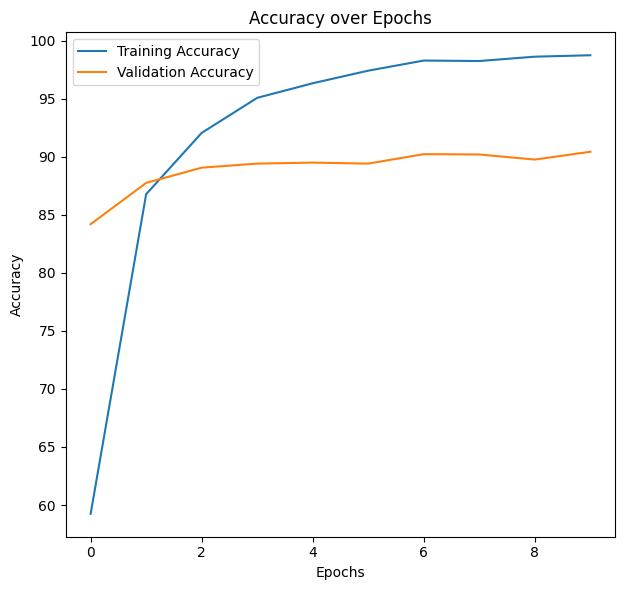

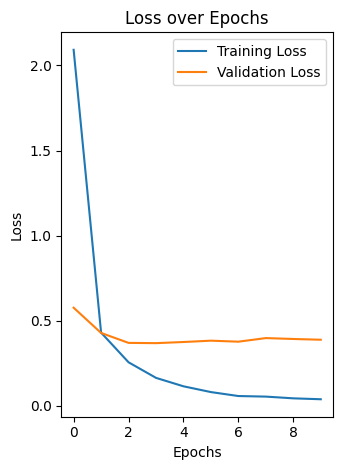

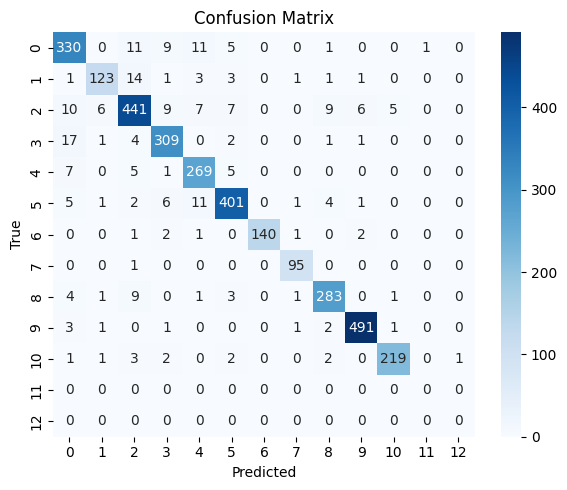

In [7]:
# Train and Evaluate EfficientNet B0
print("\nTraining efficientnetB0:\n")
efficientnetB0 = EfficientNet.from_pretrained('efficientnet-b0')
efficientnetB0 = changeModelHead(efficientnetB0)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efficientnetB0.parameters(), lr = 1e-4)

bestModel, bestAccuracy, trainAccuracies, valAccuracies, trainLosses, valLosses = trainModel(efficientnetB0, trainLoader, valLoader, optimizer, criterion, device, iterations)

testAccuracy, testLoss, testPredictions, testLabels, precision, recall, f1 = evaluateModel(bestModel, testLoader, device, criterion)

if bestAccuracy > bestAccuracyAfterAllExperiments:
    bestAccuracyAfterAllExperiments = bestAccuracy
    bestModelAfterAllExperiments = bestModel
    bestModelNameAfterAllExperiments = "efficientnetB0"

# Plot metrics for EfficientNet B0
plotMetrics(trainAccuracies, valAccuracies, trainLosses, valLosses, testLabels, testPredictions)


Training mobilenetV3Large:

Iteration 1/10: Train Loss: 0.8127, Train Accuracy: 74.2449%, Val Loss: 0.4310, Val Accuracy: 86.4431%
Iteration 2/10: Train Loss: 0.2696, Train Accuracy: 91.0197%, Val Loss: 0.3175, Val Accuracy: 89.8542%
Iteration 3/10: Train Loss: 0.1366, Train Accuracy: 95.7125%, Val Loss: 0.3106, Val Accuracy: 90.4082%
Iteration 4/10: Train Loss: 0.0699, Train Accuracy: 97.9627%, Val Loss: 0.3603, Val Accuracy: 89.7668%
Iteration 5/10: Train Loss: 0.0493, Train Accuracy: 98.3783%, Val Loss: 0.3848, Val Accuracy: 90.0292%
Iteration 6/10: Train Loss: 0.0437, Train Accuracy: 98.6114%, Val Loss: 0.3863, Val Accuracy: 89.1545%
Iteration 7/10: Train Loss: 0.0335, Train Accuracy: 98.8952%, Val Loss: 0.3963, Val Accuracy: 90.2915%
Iteration 8/10: Train Loss: 0.0246, Train Accuracy: 99.2702%, Val Loss: 0.4024, Val Accuracy: 90.5539%
Iteration 9/10: Train Loss: 0.0241, Train Accuracy: 99.2499%, Val Loss: 0.4196, Val Accuracy: 90.3207%
Iteration 10/10: Train Loss: 0.0223, Train A

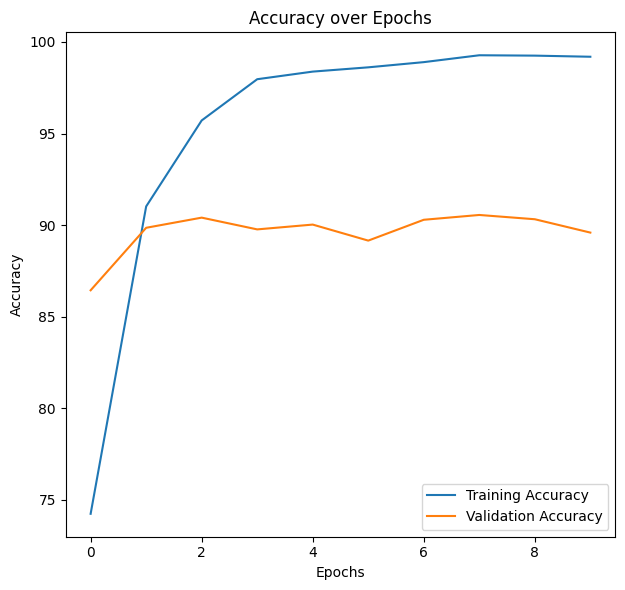

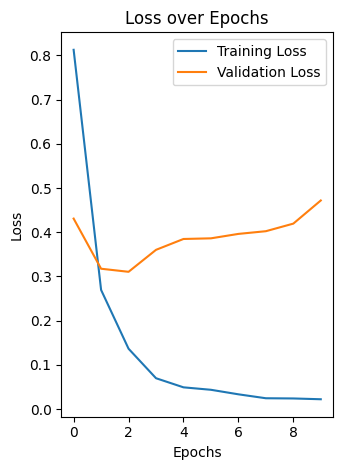

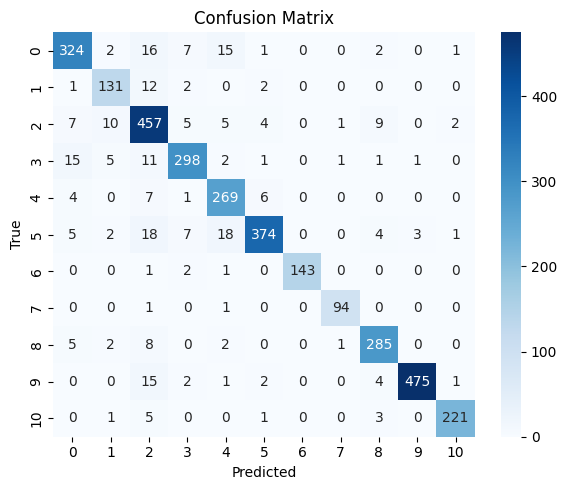

In [8]:
# Train and Evaluate MobileNetV3 Large
print("\nTraining mobilenetV3Large:\n")
mobilenetV3Large = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.DEFAULT)
mobilenetV3Large = changeModelHead(mobilenetV3Large)
optimizer = torch.optim.Adam(mobilenetV3Large.parameters(), lr = 1e-4)

bestModel, bestAccuracy, trainAccuracies, valAccuracies, trainLosses, valLosses = trainModel(mobilenetV3Large, trainLoader, valLoader, optimizer, criterion, device, iterations)

testAccuracy, testLoss, testPredictions, testLabels, precision, recall, f1 = evaluateModel(bestModel, testLoader, device, criterion)

if bestAccuracy > bestAccuracyAfterAllExperiments:
    bestAccuracyAfterAllExperiments = bestAccuracy
    bestModelAfterAllExperiments = bestModel
    bestModelNameAfterAllExperiments = "mobilenetV3Large"

# Plot metrics for MobileNetV3 Large
plotMetrics(trainAccuracies, valAccuracies, trainLosses, valLosses, testLabels, testPredictions)



Training resnet50:

Iteration 1/10: Train Loss: 0.7487, Train Accuracy: 77.3870%, Val Loss: 0.3311, Val Accuracy: 90.1458%
Iteration 2/10: Train Loss: 0.1762, Train Accuracy: 94.6888%, Val Loss: 0.2890, Val Accuracy: 91.2245%
Iteration 3/10: Train Loss: 0.0845, Train Accuracy: 97.5066%, Val Loss: 0.2696, Val Accuracy: 92.1574%
Iteration 4/10: Train Loss: 0.0471, Train Accuracy: 98.6925%, Val Loss: 0.2810, Val Accuracy: 92.0991%
Iteration 5/10: Train Loss: 0.0416, Train Accuracy: 98.9256%, Val Loss: 0.2944, Val Accuracy: 91.8659%
Iteration 6/10: Train Loss: 0.0341, Train Accuracy: 98.8851%, Val Loss: 0.2832, Val Accuracy: 92.1574%
Iteration 7/10: Train Loss: 0.0304, Train Accuracy: 99.1385%, Val Loss: 0.3273, Val Accuracy: 90.8455%
Iteration 8/10: Train Loss: 0.0408, Train Accuracy: 98.7837%, Val Loss: 0.3095, Val Accuracy: 91.8076%
Iteration 9/10: Train Loss: 0.0306, Train Accuracy: 99.0776%, Val Loss: 0.3249, Val Accuracy: 91.4869%
Iteration 10/10: Train Loss: 0.0223, Train Accuracy:

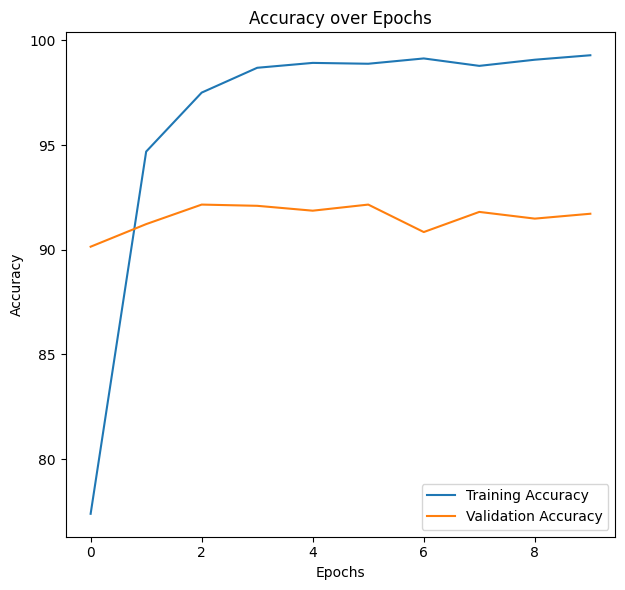

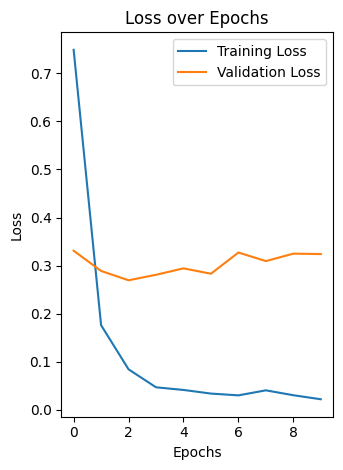

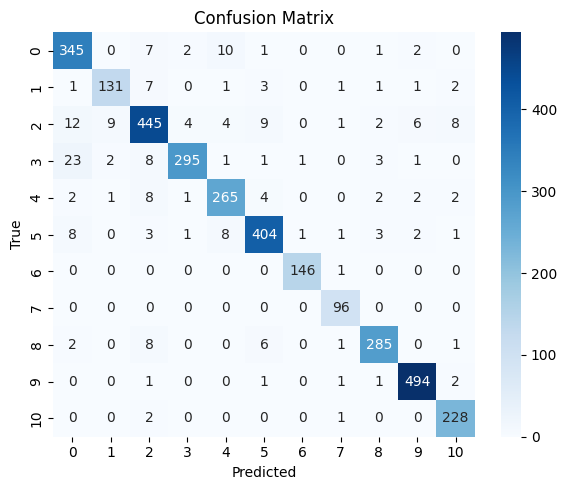

In [9]:
# Train and Evaluate ResNet50
print("\nTraining resnet50:\n")
resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
resnet50 = changeModelHead(resnet50)
optimizer = torch.optim.Adam(resnet50.parameters(), lr = 1e-4)

bestModel, bestAccuracy, trainAccuracies, valAccuracies, trainLosses, valLosses = trainModel(resnet50, trainLoader, valLoader, optimizer, criterion, device, iterations)

testAccuracy, testLoss, testPredictions, testLabels, precision, recall, f1 = evaluateModel(bestModel, testLoader, device, criterion)

if bestAccuracy > bestAccuracyAfterAllExperiments:
    bestAccuracyAfterAllExperiments = bestAccuracy
    bestModelAfterAllExperiments = bestModel
    bestModelNameAfterAllExperiments = "resnet50"

# Plot metrics for ResNet50
plotMetrics(trainAccuracies, valAccuracies, trainLosses, valLosses, testLabels, testPredictions)

In [ ]:
print("Best Model: ", bestModelNameAfterAllExperiments)
print("Best Model's Accuracy: ", bestAccuracyAfterAllExperiments)

Best Model:  resnet50
Best Model's Accuracy:  92.15743440233236
